In [27]:
import tensorflow as tf
! pip install tensorflow_hub
import tensorflow_hub as hub
! pip install tensorflow-text
import tensorflow_text
! pip install pandas 
import pandas as pd

import pandas as pd
pd.read_csv('safedownsampled.csv')


,Unnamed: 0,body,class
0,10195,use Perl Daily Headline MailerDynDNS.org Offer...,Safe Email
1,8911,conference on catalan studies ( linguistic sec...,Safe Email
2,3284,re : transwestern weekly report lindy - we rec...,Safe Email
3,4432,"sum : dets and number about a month ago , i po...",Safe Email
4,10211,Mike Masnick wrote:\n>Why is it that people do...,Safe Email
...,...,...,...
3182,708,"high frequency market data analysis stinson , ...",Safe Email
3183,1154,"fw : mark boland - cv vince : tony vasut , ano...",Safe Email
3184,2464,re : meter 0980438 - acock production ? ? ? ? ...,Safe Email
3185,2804,[Barry]\n> Here's an interesting thing to test...,Safe Email


### **After Down sampling the "big safe emails" to 3k safe email to be balanced with phishing**

In [28]:

import pandas as pd

df_ph = pd.read_csv('body_and_class.csv')
df_safe = pd.read_csv('safe_downsampled.csv')

df_ph = df_ph.drop('Unnamed: 0', axis=1, errors='ignore')
df_ph= df_ph.drop_duplicates()

df_safe = df_safe.drop('Unnamed: 0', axis=1, errors='ignore')
df_safe = df_safe.drop_duplicates()

print(df_ph, df_safe)

df_balanced = pd.concat([df_safe,df_ph])


print(df_balanced.shape)
df_balanced = df_balanced.sample(frac=1, random_state=42)

df_balanced.groupby('class').describe()

print("Safe",len(df_safe))
print("Phishing",len(df_ph))

                                                   body     class
0     eBay Suspension\neBay Suspension\nNeed Help?\n...  phishing
1     Dear LaSalle Member,\nAs part of our continuin...  phishing
2       But I don't Pokemon in 1878 in 1874 Shall we...  phishing
3     Dear eBay member,\nDear eBay user,\nDuring our...  phishing
4     Dear valued customer\nNeed Help?\nWe regret to...  phishing
...                                                 ...       ...
3182  Dear NAFCU member,\nAs part of our security me...  phishing
3183  lay flog, me zing sell, net sick burr macepay ...  phishing
3184  eBay\nBilling \n          confirmation center\...  phishing
3185  Dear Valued Customer\nWe are committed to prot...  phishing
3186  National Credit Union Administration  Notifica...  phishing

[3187 rows x 2 columns]                                                    body       class
0     use Perl Daily Headline MailerDynDNS.org Offer...  Safe Email
1     conference on catalan studies ( linguisti

In [29]:

df_ph = df_balanced[df_balanced['class'] == 'phishing']
df_safe = df_balanced[df_balanced['class'] == 'Safe Email']
from sklearn.utils import resample
df_ph_downsampled = resample(df_ph, replace=False, n_samples=300, random_state=42)
df_safe_downsampled = resample(df_safe, replace=False, n_samples=3000, random_state=42)

df_downsampled = pd.concat([df_ph_downsampled, df_safe_downsampled])

df_downsampled = df_downsampled.sample(frac=1, random_state=42)
print(len(df_downsampled))


3300


### **10% Phishing 90% Safe emails:**

### Map:  Phishing => 1 . Safe => 0




In [30]:

df_downsampled['phishing']=df_downsampled['class'].apply(lambda x: 1 if x =='phishing' else 0)
df_downsampled.sample(5)



,body,class,phishing
2894,Dear Customers!\nIn\nconnection with hard incr...,phishing,1
493,new book : language acquisition literacy devel...,Safe Email,0
2641,Lacking in a _____\n\t / ___ \\n\t / /...,Safe Email,0
2480,"summary : chomsky 's "" single mutation "" a cou...",Safe Email,0
2512,"romance ling davis , stuart @ napoli , donna j...",Safe Email,0


### **Split it into training and test data set**

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_downsampled['body'],df_downsampled['phishing'],
                                                    stratify=df_downsampled['phishing'],random_state=42,test_size=0.3)

X_train.head(4)

2641    Lacking in a  _____\n\t     / ___ \\n\t    / /...
148     On Thu, 2002-08-15 at 10:53, Erik Williamson w...
3062    Another thing I see in debian but not in my RH...
1185    [Tim]\n> One effect of getting rid of MINCOUNT...
Name: body, dtype: object


### **Using BERT model and get embeding vectors**


In [32]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [33]:
text_input= tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")
preprocessed_text= bert_preprocess(text_input)
outputs= bert_encoder(preprocessed_text)

dropout_layer = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
dense_layer = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(dropout_layer)


model = tf.keras.Model(inputs=[text_input], outputs = [dense_layer])
print( model.summary() )

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

In [34]:
len(X_train)

2310

In [35]:

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)



# **Model Train**

In [44]:

'''
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

X_train_preprocessed = np.array([str(sentence) for sentence in X_train])
X_test_preprocessed = np.array([str(sentence) for sentence in X_test])


early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

class_weights = {0: 1, 1: 10}  # 0 corresponds to the majority class, and 1 corresponds to the minority class
history = model.fit(X_train_preprocessed, y_train, epochs=10, validation_split=0.2, class_weight=class_weights, callbacks=[early_stopping, checkpoint])
'''



import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

# Convert Pandas Series to NumPy arrays
X_train_preprocessed = np.array([str(sentence) for sentence in X_train])
X_test_preprocessed = np.array([str(sentence) for sentence in X_test])
y_train = np.array(y_train)

# Splitting data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_preprocessed, y_train, test_size=0.2, random_state=42)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_split, y_train_split))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_split, y_val_split))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_preprocessed, y_test))

test_df = pd.DataFrame({'X_test_preprocessed': X_test_preprocessed, 'y_test': y_test})
test_df.to_csv('Bert_Test_Subset.csv', index=False)



# Define batch size
batch_size = 32

# Shuffle and batch the datasets
train_dataset = train_dataset.shuffle(buffer_size=len(X_train_split)).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

# Defining callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Define class weights
class_weights = {0: 1, 1: 10}  # Assuming binary classification

# Fit the model
history = model.fit(X_train_split, y_train_split, epochs=10, validation_data=(X_val_split, y_val_split), class_weight=class_weights, callbacks=[early_stopping, checkpoint])
'''
# Plotting the accuracy and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
'''

Epoch 1/10
58/58 [==============================] - 29s 496ms/step - loss: 0.5283 - accuracy: 0.9194 - precision: 0.5267 - recall: 0.9024 - val_loss: 0.2785 - val_accuracy: 0.9394 - val_precision: 0.6324 - val_recall: 0.9348
Epoch 2/10
58/58 [==============================] - 27s 469ms/step - loss: 0.5200 - accuracy: 0.9058 - precision: 0.4837 - recall: 0.9024 - val_loss: 0.1742 - val_accuracy: 0.9697 - val_precision: 0.8200 - val_recall: 0.8913
Epoch 3/10
58/58 [==============================] - 26s 443ms/step - loss: 0.5255 - accuracy: 0.9242 - precision: 0.5465 - recall: 0.8598 - val_loss: 0.2987 - val_accuracy: 0.9177 - val_precision: 0.5500 - val_recall: 0.9565
Epoch 4/10
58/58 [==============================] - 27s 473ms/step - loss: 0.5129 - accuracy: 0.9091 - precision: 0.4934 - recall: 0.9085 - val_loss: 0.2876 - val_accuracy: 0.9199 - val_precision: 0.5570 - val_recall: 0.9565
Epoch 5/10
58/58 [==============================] - 29s 509ms/step - loss: 0.4864 - accuracy: 0.9221

"\n# Plotting the accuracy and validation accuracy\nplt.subplot(1, 2, 1)\nplt.plot(history.history['accuracy'])\nplt.plot(history.history['val_accuracy'])\nplt.title('Model Accuracy')\nplt.xlabel('Epoch')\nplt.ylabel('Accuracy')\nplt.legend(['Train', 'Validation'], loc='upper left')\nplt.show()\n"

# **Model Traning Evaluation**

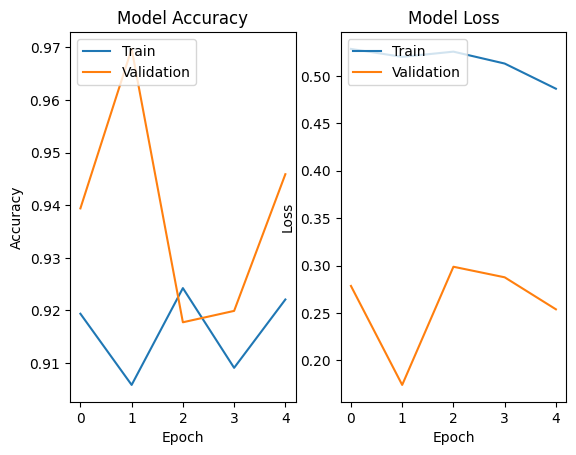

In [45]:
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


31/31 [==============================] - 12s 366ms/step


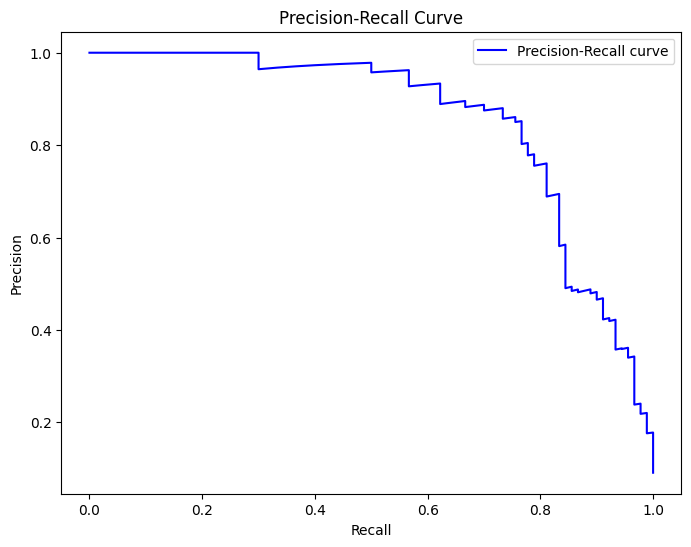

In [46]:

# Evaluate model
results = model.evaluate(test_dataset)

# Predict probabilities for the test data
y_pred = model.predict(test_dataset).ravel()

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)


# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()



In [47]:
auc_pr = auc(recall, precision)
print(f'AUC-PR: {auc_pr}')

AUC-PR: 0.8537782283225558


In [48]:
accuracy = results[model.metrics_names.index('accuracy')]
precision = results[model.metrics_names.index('precision')]
recall = results[model.metrics_names.index('recall')]

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

Accuracy: 0.965656578540802
Precision: 0.8500000238418579
Recall: 0.7555555701255798


# **Model Saving**

In [ ]:
# Assuming your model is already trained and stored in the variable 'model'

# Define the file path where you want to save your model
model_path = 'my_model.h5'

# Save the model
model.save(model_path)

print("Model saved successfully at:", model_path)



Model saved successfully at: my_model.h5


# **Modle Loading**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the saved model


# Load the saved model
#model_path = 'my_model_best_acc_95.h5'

loaded_model = load_model('my_model_best_acc_95.h5')



# Make predictions using the loaded model
y_pred = loaded_model.predict(["Phishing, you will 10k dollars from this email, just click the link."])

print(y_pred)
# Convert probabilities to class labels (assuming binary classification)
accuracy = results[loaded_model.metrics_names.index('accuracy')]
precision = results[loaded_model.metrics_names.index('precision')]
recall = results[loaded_model.metrics_names.index('recall')]

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')


ValueError: Unknown layer: KerasLayer. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.